# **CVPR** - Assignment 2 
----------------------------------
----------------------------------
# Bojana Počuča and Marco Nobile

## Imports
----------------------------------

In [1]:
import cv2
import matplotlib.path as path
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
import timeit
import time
from IPython.display import HTML

## Reading and visualising the images
----------------------------------

In [2]:
img1 = cv2.imread('template1.png') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) #shape (472, 307, 3)
img2 = cv2.imread('target1.png') 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) #shape (750, 1000, 3)

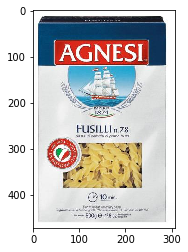

In [3]:
plt.imshow(img1);

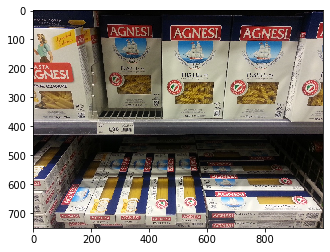

In [4]:
plt.imshow(img2);

## Feature detection with **SURF** (Speeded Up Robust Features) 
----------------------------------
After trying to do feature detection with SIFT, we wanted to test how SURF works and indeed it worked faster, so we decided to go with SURF instead.

In [5]:
surf = cv2.xfeatures2d.SURF_create((500))

Keypoint and descriptor extraction from SURF.

In [6]:
 # TEMPLATE IMAGE
kp1, des1 = surf.detectAndCompute(img1,None) # len(kp1) = 824
# TARGET IMAGE
kp2, des2 = surf.detectAndCompute(img2,None) # len(kp2) = 4279

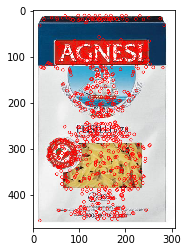

In [7]:
# Drawing all the template keypoints 
img1_kp1 = cv2.drawKeypoints(img1,kp1,None,(255,0,0),2)
plt.imshow(img1_kp1),plt.show();

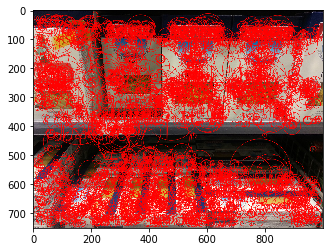

In [8]:
# Drawing all the target keypoints
img2_kp2 = cv2.drawKeypoints(img2,kp2,None,(255,0,0),4)
plt.imshow(img2_kp2),plt.show();

Building keypoint matrices for a better representation. 

In [9]:
kp_target = np.empty_like([kp2[0].pt])
kp_template = np.empty_like([kp1[0].pt])

In [10]:
for i in range(len(kp2)):
    kp_target = np.append(kp_target, [kp2[i].pt], axis=0)
kp_target = kp_target[1:]
print("Shape of the target image is {}".format(kp_target.shape))

for i in range(len(kp1)):
    kp_template = np.append(kp_template, [kp1[i].pt], axis=0)
kp_template = kp_template[1:]
print("Shape of the template image is {}".format(kp_template.shape))

Shape of the target image is (4279, 2)
Shape of the template image is (824, 2)


## Clustering
----------------------------------
After clustering the keypoints with **Mean Shift** (as a sort of preprocessing), we realized that we still are retrieving *false* mappings and that the Homographies are *not as precise* as we would want them to be. In order to solve this problem, our idea was based on *'filtering out'* not only the keypoints but the descriptors as well. We did this by applying the MeanShift clustering technique 3 times :
    1. Target keypoint clustering (Distance clustering) 
    2. Target descriptor clustering
    3. Template descriptor clustering

In [11]:
def mean_shift(feature, bw_q, n_samples=None, bs=True, ca=False):
    bandwidth = estimate_bandwidth(feature, quantile=bw_q, n_samples=n_samples)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=bs, cluster_all=ca)
    ms.fit(feature) 
    # retrieves labels and centroids
    labels = ms.labels_ 
    cluster_centers = ms.cluster_centers_ 
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique) 
    print("Number of estimated clusters : %d" % n_clusters_)
    return cluster_centers, labels

In [12]:
# Keypoint distance clusters in target image
dist_centers, dist_clusters = mean_shift(kp_target, bw_q=0.1, n_samples=len(kp1), bs=False, ca=False)
# Descriptor clusters in target image
des_centers, des_clusters = mean_shift(des2, bw_q=0.05, bs=True, ca=True)
# Descriptor clusters in template image
des_t_centers, des_t_clusters = mean_shift(des1, bw_q=0.05, bs=True, ca=True)

Number of estimated clusters : 9
Number of estimated clusters : 3
Number of estimated clusters : 3


Obtaining and saving all the labels of 'keypoint clustering' and counting the number of elements in each of the labels. 

In [13]:
clust_labels, counts = np.unique(dist_clusters, return_counts=True)
print (np.asarray((clust_labels, counts)).T)

[[ -1 661]
 [  0 573]
 [  1 509]
 [  2 658]
 [  3 515]
 [  4 342]
 [  5 388]
 [  6 364]
 [  7 269]]


Obtaining and saving all the labels of 'template descriptor clustering' and counting the number of elements in each of the labels. 

In [14]:
t_clust_labels, counts = np.unique(des_t_clusters, return_counts=True)
print (np.asarray((t_clust_labels, counts)).T)

[[  0 391]
 [  1 418]
 [  2  15]]


## Visualisation of the clustering
----------------------------------
Plotting all the keypoints of template image, coloured by clusters.

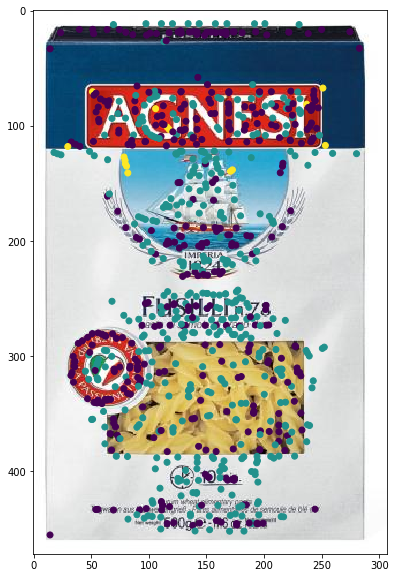

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img1)
ax.scatter(kp_template[:,0],kp_template[:,1], c=des_t_clusters);

1) Plotting the keypoints of target image, coloured by target image descriptors. <br>
2) Plotting the 'distance clusters' of target image (discarding all the points belonging to the -1 (or 'outlier') label).

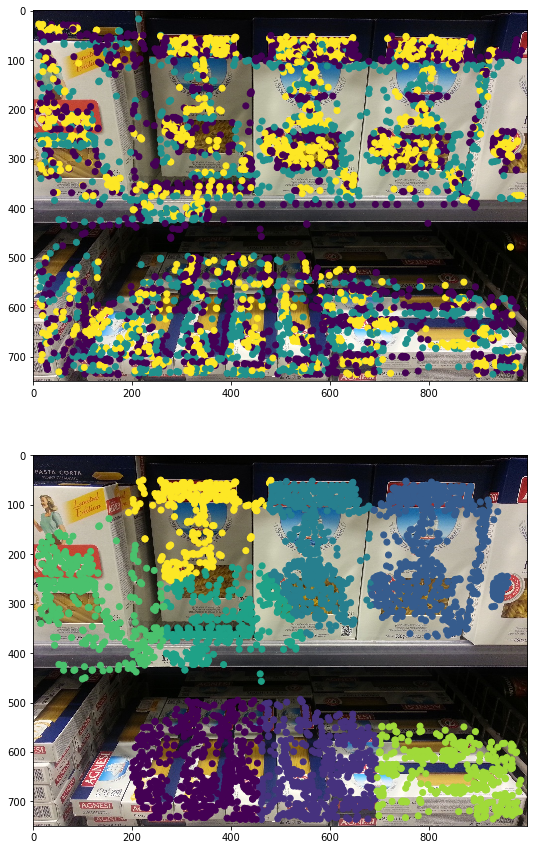

In [16]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
ax[0].imshow(img2)
ax[0].scatter(kp_target[:,0],kp_target[:,1], c=des_clusters);
ax[1].imshow(img2)
discard_outliers = (dist_clusters == -1)
ax[1].scatter(kp_target[~discard_outliers,0],kp_target[~discard_outliers,1], c=dist_clusters[~discard_outliers]);

In [17]:
# Transforming keypoints into arrays
kp1 = np.array(kp1)
kp2 = np.array(kp2)

## Feature (Descriptor) matching with  __FLANN__ (Fast Library for Approximate Nearest Neighbors) and multi model fitting with __Sequential RANSAC__.
----------------------------------

First we iterate trough all the 'distance clusters' and 'mask out' everything but the keypoints for the current cluster (iteration) we are in. Then for each of those clusters, we go trough all the 'template descriptor clusters' and find the *closest*, most optimal 'target descriptor cluster' so that we can 'put a mask on' the descriptors along with the keypoints. This way we **focus** only on a certain set of descriptors **for each** template clustered in the target image. 

## Discarding the bad homographies
All of the previously mentioned steps are considered as _preprocessing_ of the keypoints and, most importantly, descriptors, which will then be fed to **FLANN** in order to find the most optimal matched descriptors. After finding the matches, we will do a _Ratio test_ that will tell us the correct matches based on the nearest-neighbor distance ratio test, and disregard all the others.<br>
However, the results were still not good enough - not all the retrieved homographies were correct. To tackle this problem, we added a simple condition where we discard the homographies which have a lower number of matched points then a certain _threshold_ as well as those whose _determinant_ is very low.
<br>
We can see that the results we obtain for the tagret image 1 are very good, but as expected, when we tried this solution on the second target image, the results were not as good as we expected. In the second Jupyter Notebook we still followed the same idea but made some slight changes. The second method worked perfectly for both provided images.

Could not find homography for cluster -1
Could not find homography for cluster 0
Could not find homography for cluster 1


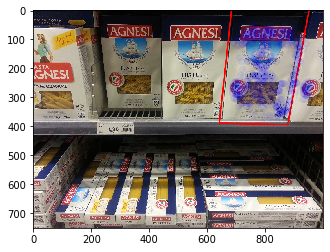

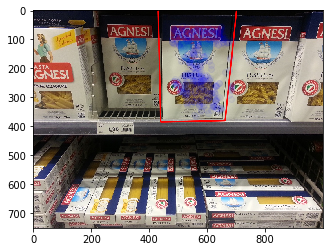

Could not find homography for cluster 4
Could not find homography for cluster 5
Could not find homography for cluster 6


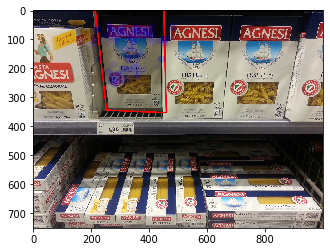

In [18]:
for i in clust_labels:
    # Target keypoint mask
    mask_pts_ = np.array(i==dist_clusters)
    kpts_ = kp_target[mask_pts_]
    
    src_pts=[]
    dst_pts=[]
    
    for descriptor in t_clust_labels:
        center = des_t_centers[descriptor,:] #1x64
        distance = np.linalg.norm(des_centers-center,2,axis=1) #3x64-1x64 -> 3x64; 3x1
        corr_clust = np.argmin(distance)
    
        # Target descriptor mask
        mask_descr_ = np.array(corr_clust==des_clusters)
        # Template descriptor mask
        mask_t_descr_ = np.array(descriptor==des_t_clusters)
        # Merging the masks for the target image (filtering based on both keypoints and descriptors)
        main_mask = mask_pts_ & mask_descr_
        
        # FLANN
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Filtering out the descriptors based on masks
        filtered_des1 = des1[mask_t_descr_,:] #template
        filtered_des2 = des2[main_mask,:] #target
        
        # Filtering out the keypoints based on masks
        filtered_kp1 = kp1[mask_t_descr_] #template
        filtered_kp2 = kp2[main_mask] #target
    
        # Descriptor matching with FLANN
        matches = flann.knnMatch(filtered_des1, filtered_des2, 2)
        
        # RATIO TEST
        for m,n in matches: 
            if m.distance < 0.8*n.distance: 
                src_pts.append(filtered_kp1[m.queryIdx].pt)
                dst_pts.append(filtered_kp2[m.trainIdx].pt)
        
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    
    # RANSAC
    if len(src_pts) > 3:
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)
        # Discarding Homography (M) with very small determinant (very close to 0) 
        if M is None or np.linalg.det(M) < 1E-2: 
            print(f"Could not find homography for cluster {i}")
        else:
            matchesMask = mask.ravel().tolist()
#             print('Determinant of the Homography: {}'.format(np.linalg.det(M)))

           # Plotting
            h,w = img1.shape[0], img1.shape[1]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            img2_k = cv2.polylines(np.copy(img2),[np.int32(dst)],True,255,3, cv2.LINE_AA)
            draw_params = dict(matchColor=(120, 45, 200),  # draw matches in purple color
                              singlePointColor=None,
                              matchesMask=matchesMask,  # draw only inliers
                              flags=2)
            plt.imshow(img2_k)
            plt.scatter(kp_target[mask_pts_, 0], kp_target[mask_pts_, 1], c='b', alpha=0.05)
            plt.show()